In [281]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/machiavellianism-pics/Picture2.png
/kaggle/input/machiavellianism-pics/Picture1.png
/kaggle/input/machiavellianism-pics/Picture3.png
/kaggle/input/competitionfile/train.csv
/kaggle/input/competitionfile/test_x.csv
/kaggle/input/competitionfile/sample_submission.csv


# 마키아벨리즘 심리테스트를 활용하여 테스트 참가자의 국가 선거 투표 여부 예측 (Classification)

# Importing Libraries

In [282]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#전처리
from sklearn.preprocessing import LabelEncoder, StandardScaler

#데이터분리
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV

#모델링
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#성과 평가 지표
from sklearn.metrics import accuracy_score, mean_squared_error

# 1. Data Load

In [283]:
train=pd.read_csv('/kaggle/input/competitionfile/train.csv', index_col=0)
test=pd.read_csv('/kaggle/input/competitionfile/test_x.csv', index_col=0)
submission=pd.read_csv('/kaggle/input/competitionfile/sample_submission.csv', index_col=0)  
print(train.shape)
print(test.shape)
print(submission.shape)

(45532, 77)
(11383, 76)
(11383, 1)


In [284]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
display(train.tail(20))

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,QfA,QfE,QgA,QgE,QhA,QhE,QiA,QiE,QjA,QjE,QkA,QkE,QlA,QlE,QmA,QmE,QnA,QnE,QoA,QoE,QpA,QpE,QqA,QqE,QrA,QrE,QsA,QsE,QtA,QtE,age_group,education,engnat,familysize,gender,hand,married,race,religion,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10,urban,voted,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
45512,2.0,681,1.0,1701,2.0,1147,2.0,997,2.0,1054,3.0,409,3.0,463,1.0,788,3.0,1197,3.0,1931,5.0,871,5.0,1130,4.0,500,4.0,330,3.0,490,2.0,588,4.0,951,5.0,1390,4.0,550,2.0,1138,10s,1,1,2,Female,1,1,Asian,Hindu,2,3,1,2,1,1,2,4,3,4,2,2,0,0,0,1,1,0,1,0,0,1,1,0,1,0,1,1
45513,4.0,392,1.0,794,2.0,2781,4.0,1042,4.0,1501,5.0,630,5.0,2434,1.0,1595,5.0,2535,1.0,1354,5.0,799,3.0,1609,2.0,652,5.0,298,2.0,866,2.0,1881,4.0,997,4.0,1215,2.0,1043,1.0,2586,50s,3,1,4,Male,1,2,White,Christian_Protestant,6,7,7,7,7,7,7,7,7,7,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45514,1.0,692,2.0,11204,4.0,899,2.0,1249,4.0,1069,2.0,899,2.0,991,1.0,1745,4.0,2057,4.0,1223,4.0,1418,5.0,1278,4.0,844,2.0,440,2.0,1481,1.0,1068,2.0,595,4.0,1066,2.0,945,2.0,820,20s,2,1,1,Female,1,1,White,Atheist,6,2,4,0,4,0,1,2,5,4,3,1,0,1,0,1,1,0,1,1,0,1,1,0,1,1,1,1
45515,1.0,720,2.0,3028,5.0,495,1.0,559,1.0,1162,1.0,742,1.0,704,1.0,1578,5.0,1571,4.0,1798,5.0,861,5.0,1288,5.0,666,1.0,635,4.0,1411,2.0,1183,4.0,1453,2.0,2046,5.0,585,2.0,1517,10s,2,1,2,Female,1,1,Other,Agnostic,3,1,4,0,0,2,4,1,4,6,3,1,0,0,0,1,1,0,1,1,1,1,1,0,1,0,1,1
45516,2.0,314,2.0,1286,4.0,544,1.0,934,2.0,1531,1.0,745,1.0,602,2.0,900,2.0,851,2.0,699,1.0,804,5.0,710,4.0,514,1.0,323,4.0,751,1.0,1475,1.0,424,1.0,602,5.0,494,5.0,546,30s,4,2,2,Male,1,1,White,Agnostic,2,0,1,4,0,2,5,4,2,2,3,1,0,0,0,1,1,0,1,1,0,1,1,0,1,0,1,1
45517,1.0,439,5.0,747,5.0,738,1.0,600,1.0,517,1.0,258,1.0,465,3.0,1342,1.0,800,5.0,760,1.0,701,5.0,499,5.0,970,1.0,331,5.0,340,5.0,479,1.0,1053,1.0,2307,5.0,368,5.0,849,10s,1,1,2,Male,1,1,White,Atheist,6,1,0,6,1,0,6,6,0,6,3,2,0,0,1,1,1,0,1,1,0,1,1,0,1,0,1,1
45518,1.0,476,5.0,2440,5.0,1545,1.0,1676,1.0,3086,4.0,701,1.0,595,1.0,1610,1.0,3410,5.0,2200,5.0,838,5.0,879,3.0,4675,5.0,590,1.0,795,1.0,780,4.0,1501,3.0,11469,5.0,800,3.0,1664,40s,2,1,4,Female,1,2,White,Atheist,2,2,4,2,0,2,0,6,4,6,2,2,0,1,0,1,1,1,1,1,0,1,1,0,1,1,1,1
45519,2.0,941,1.0,12535,1.0,1261,2.0,2278,5.0,5524,2.0,1540,5.0,25985,1.0,5606,5.0,3330,1.0,1217,5.0,1130,1.0,865,4.0,2079,4.0,541,1.0,740,2.0,1297,3.0,2731,5.0,1686,1.0,2482,2.0,2317,10s,2,1,2,Female,1,1,White,Christian_Catholic,1,6,1,6,2,2,1,6,3,6,2,2,0,0,0,0,1,0,1,1,0,1,1,0,1,0,1,1
45520,4.0,728,1.0,1669,4.0,1397,3.0,714,1.0,1457,2.0,711,4.0,776,1.0,1031,4.0,2185,4.0,551,5.0,802,4.0,1921,1.0,1142,3.0,595,1.0,928,4.0,740,3.0,533,5.0,1064,3.0,683,1.0,780,40s,2,1,3,Female,1,3,Other,Agnostic,5,5,1,4,2,1,1,4,1,4,3,1,0,0,0,1,1,0,1,1,0,1,1,0,1,1,1,1


In [285]:
train.columns

Index(['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE',
       'age_group', 'education', 'engnat', 'familysize', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'voted', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13'],
      dtype='object')

# 2. Data Exploration / Preprocessing

## 2- 1. 결측치 처리

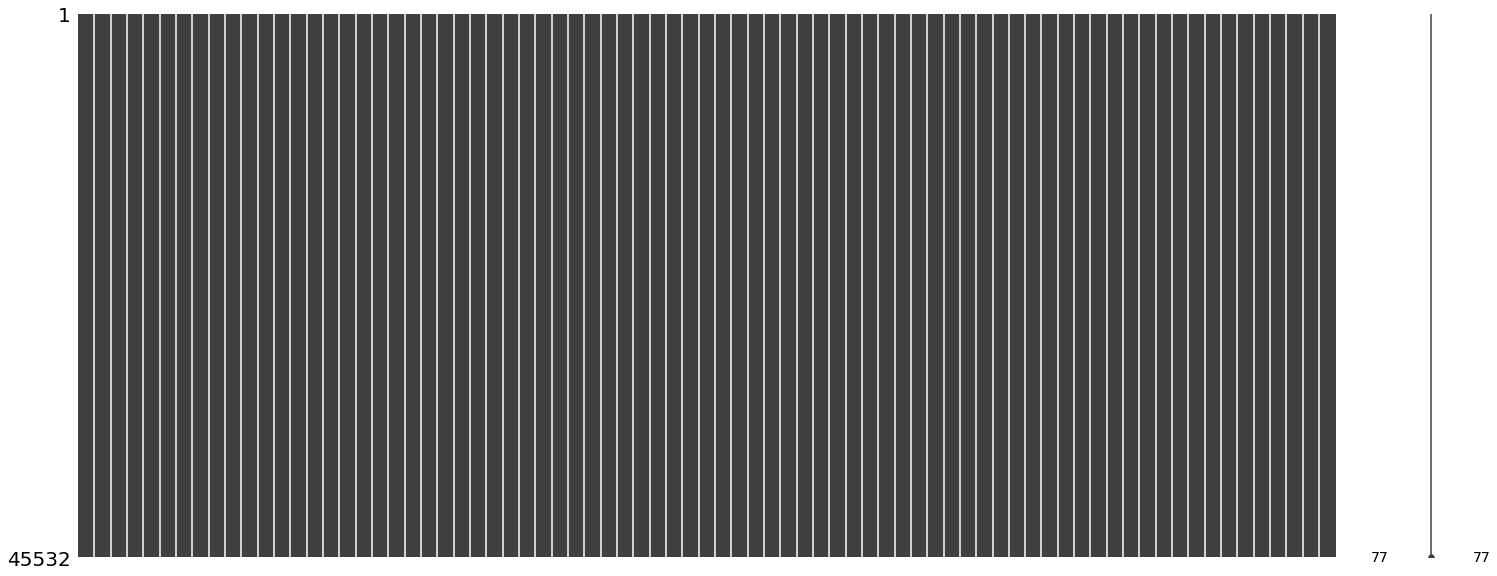

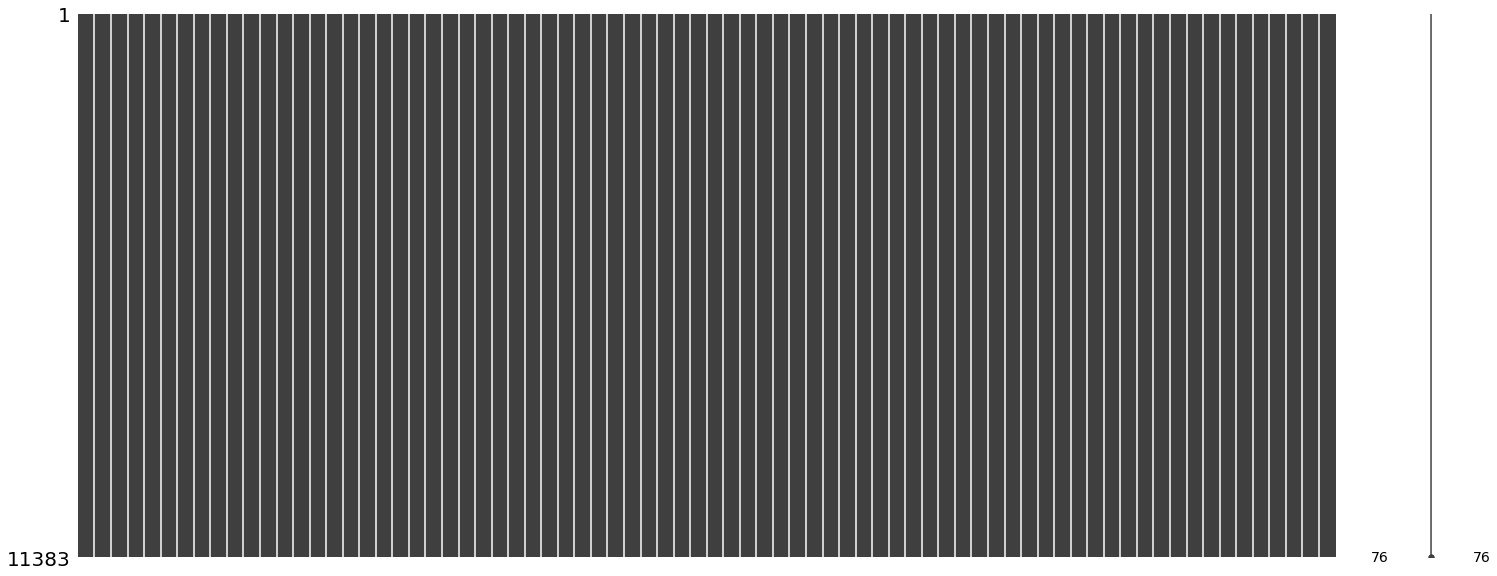

train :  QaA           0
QaE           0
QbA           0
QbE           0
QcA           0
QcE           0
QdA           0
QdE           0
QeA           0
QeE           0
QfA           0
QfE           0
QgA           0
QgE           0
QhA           0
QhE           0
QiA           0
QiE           0
QjA           0
QjE           0
QkA           0
QkE           0
QlA           0
QlE           0
QmA           0
QmE           0
QnA           0
QnE           0
QoA           0
QoE           0
QpA           0
QpE           0
QqA           0
QqE           0
QrA           0
QrE           0
QsA           0
QsE           0
QtA           0
QtE           0
age_group     0
education     0
engnat        0
familysize    0
gender        0
hand          0
married       0
race          0
religion      0
tp01          0
tp02          0
tp03          0
tp04          0
tp05          0
tp06          0
tp07          0
tp08          0
tp09          0
tp10          0
urban         0
voted         0
wf_01         0

In [286]:
import missingno as msno
#표에 있는 결측치 시각화
msno.matrix(train)
plt.show()

msno.matrix(test)
plt.show()

# 결측치 숫자로 제시
print('train : ',train.isnull().sum())
print('test : ',test.isnull().sum())

∴결측치 없다는게 확인되었습니다.

## 2-2. Dataset 나누기

### 2-2-1. 테스트 문항

In [287]:
Answers = ['QaA', 'QbA', 'QcA', 'QdA', 'QeA',
             'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 
             'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 
             'QpA', 'QqA', 'QrA', 'QsA', 'QtA']

Answers = train[Answers]
display(Answers.tail())

,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
index,,,,,,,,,,,,,,,,,,,,
45527,2.0,5.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,5.0,4.0,1.0,2.0,4.0,2.0,1.0,5.0,4.0
45528,2.0,3.0,4.0,1.0,3.0,2.0,2.0,1.0,2.0,5.0,2.0,5.0,3.0,2.0,4.0,4.0,2.0,3.0,4.0,4.0
45529,4.0,1.0,1.0,4.0,5.0,4.0,5.0,1.0,5.0,1.0,5.0,5.0,1.0,4.0,1.0,1.0,5.0,5.0,3.0,1.0
45530,1.0,3.0,4.0,2.0,1.0,1.0,1.0,1.0,5.0,1.0,5.0,5.0,4.0,3.0,1.0,1.0,4.0,4.0,4.0,1.0
45531,3.0,5.0,5.0,3.0,1.0,4.0,3.0,3.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0


### 2-2-2. 문항 응답시간

In [288]:
Dauer = ['QaE', 'QbE','QcE', 'QdE','QeE',
           'QfE','QgE','QhE','QiE','QjE',
           'QkE','QlE','QmE','QnE','QoE',
           'QpE','QqE','QrE','QsE','QtE']

Dauer = train[Dauer]
display(Dauer.tail())

,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
index,,,,,,,,,,,,,,,,,,,,
45527,1050,619,328,285,602,267,315,483,1016,278,611,215,388,299,1915,439,823,309,586,2252
45528,581,1353,1164,798,1680,560,640,1415,4494,1392,2478,1268,843,1401,1524,719,754,1118,654,1197
45529,593,857,1047,1515,1690,1253,1094,1283,2209,1764,1062,1489,1908,891,1298,1200,473,1779,1355,667
45530,747,1331,892,1281,1328,599,650,1429,1748,770,1025,742,4180,707,489,913,1301,1680,737,1124
45531,496,1827,754,1117,432,1422,545,1696,2172,7076,1087,1090,2195,431,914,620,410,736,667,1665


### 2-2-3. 인적사항

* age_group : 연령
* education : 교육 수준
* engnat : 모국어가 영어
* familysize : 형제자매 수
* gender : 성별
* hand : 필기하는 손
* married : 혼인 상태
* race : 인종
* religion : 종교
* urban : 유년기의 거주 구역

In [289]:
Personals = ['age_group','education', 'engnat','familysize', 'gender', 'hand',
           'married', 'race','religion', 'urban']

Personals = train[Personals]
display(Personals.tail())

,age_group,education,engnat,familysize,gender,hand,married,race,religion,urban
index,,,,,,,,,,
45527,10s,2,1,1,Female,3,1,White,Jewish,3
45528,30s,2,1,2,Male,1,1,White,Atheist,1
45529,10s,2,1,1,Female,1,1,White,Christian_Other,2
45530,40s,4,1,2,Male,3,1,White,Atheist,0
45531,20s,2,1,3,Male,1,1,White,Agnostic,2


### 2-2-4. 자아정체성

tp__(01~10) : items were rated "I see myself as:" _____ such that

* tp01 : Extraverted, enthusiastic.
* tp02 : Critical, quarrelsome.
* tp03 : Dependable, self-disciplined.
* tp04 : Anxious, easily upset.
* tp05 : Open to new experiences, complex.
* tp06 : Reserved, quiet.
* tp07 : Sympathetic, warm.
* tp08 : Disorganized, careless.
* tp09 : Calm, emotionally stable.
***** tp10 : Conventional, uncreative.


In [290]:
Identity = ['tp01', 'tp02', 'tp03', 'tp04', 'tp05',
            'tp06', 'tp07', 'tp08', 'tp09', 'tp10']
Identity = train[Identity]
display(Identity.tail())

,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
index,,,,,,,,,,
45527,1,2,6,1,2,6,3,0,6,4
45528,2,2,2,3,1,3,3,4,1,5
45529,4,4,2,4,0,1,0,2,1,6
45530,1,2,0,4,0,1,3,2,2,4
45531,3,2,1,2,3,0,2,3,1,2


### 해당 단어의 정의를 아는가?




* wr_(01~13) : 실존하는 해당 단어의 정의을 앎 : 1=Yes, 0=No
* wf_(01~03) : 허구인 단어의 정의를 앎 : 1=Yes, 0=No

In [291]:
Words = ['wf_01','wf_02', 'wf_03','wr_01',
         'wr_02', 'wr_03','wr_04','wr_05',
         'wr_06','wr_07', 'wr_08','wr_09',
         'wr_10', 'wr_11', 'wr_12', 'wr_13']

Words = train[Words]
display(Words.tail())

,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,
45527,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,1
45528,0,0,1,1,1,1,1,1,0,1,1,1,1,0,1,1
45529,0,0,0,1,1,0,1,1,0,1,1,0,1,0,1,1
45530,0,0,0,1,1,0,1,1,0,1,1,1,1,0,1,1
45531,1,1,1,1,1,0,1,1,0,1,1,0,1,0,1,1


## 2-3. Mach 스코어(심리테스트 결과) 산출

jhl님이 코드공유 게시판에 올려주신 마키아벨리즘 심리테스트 스코어 산출코드를 참조하여 아래 과정을 진행하였습니다.

먼저 테스트를 통해 산출된 전체적인 마키아벨리즘 테스트 스코어(이하 Mach스코어)가 국가투표 여부에 얼마나 영향을 끼치지는지 살펴보아 얻을 수 있는 Insight가 있는지 알아봅시다.

마키아벨리니즘 성향이 높을수록 +부호인 문항들에서는 높은 답변값을 내놓았을 것이고 -부호인 문항들에서는 낮은 답변값을 내놓습니다.
Mach스코어는 몇몇 문항들, 즉 음의 부호를 갖는 문항들을 Reverse하여 평균을 구한 값입니다.

하지만 몇몇 테스트 문항은 테스트 응답자들의 신상보호를 위해 비식별화되어 있습니다.
따라서 문항의 부호가 명백한 문항들과 비식별화된 문항들의 음양관계를 살펴보아야 비식별화된 문항들의 부호를 찾을 수 있습니다.
(∵ 각 문항의 값은 1~5, 혹은 -5~ - 1이므로 같은 부호의 값을 갖는다면 양의 상관관계를 가질 것이고, 반대 부호라면 음의 상관관계를 가질 것입니다.)


In [292]:
for col in Answers.loc[:,]:
    print(sorted(Answers[col].unique()))

[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]


## 2-3-1. 이미 알고 있는 -부호 문항을 reverse 처리하기

다음과 같이 모든 문항은 1~5점으로 동일하게 채점되어 있으나, 모든 문항은 같은 마키아벨리 성향을 측정하므로 음의 부호를 갖는 문항들을 reverse처리해야 각 문항 간의 상관관계를 살펴보았을 때 다같이 양의 상관관계를 갖습니다.
먼저 "QeA", "QfA", "QkA", "QqA", "QrA" 이렇게 다섯 문항은 부호가 -인 것을 이미 알고 있기 때문에 reverse 처리합니다.

In [293]:
flipping_columns = ["QeA", "QfA", "QkA", "QqA", "QrA"]

# reversed 답변값 = 6 - 표에 기재된 답변값
for flip in flipping_columns: 
    Answers[flip] = 6 - Answers[flip]

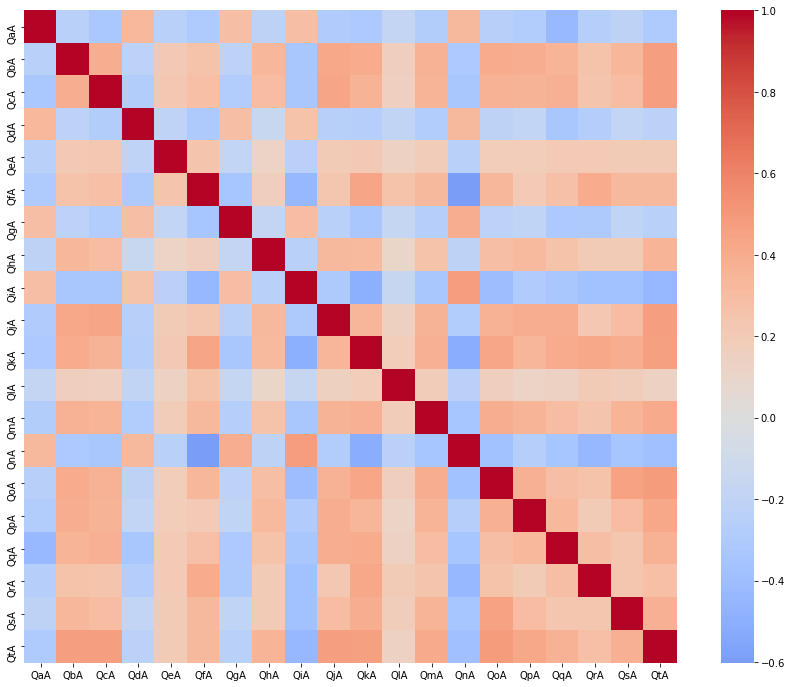

In [294]:
correlations = Answers.corr(method = 'spearman')
plt.figure(figsize = (16, 12))
sns.heatmap(correlations, cmap="coolwarm", square=True, center=0)

## 2-3-2. 확인된 Secret -부호 문항을 reverse 처리하기

Secret이 아닌 문항들간의 관계를 살펴보았을 때 모두 다 양수 correlation을 나타내는 붉은색을 띠는 것을 볼 수 있습니다.

5개의 파란줄이 눈에 띕니다. 이는 -부호를 가진 Secret 문항수와 일치합니다.

이를 통해 "QaA", "QdA", "QgA", "QiA", "QnA" 이렇게 다섯 문항이 -부호를 가진 문항이라는 걸 알 수 있습니다.

출처 : https://dacon.io/competitions/official/235647/codeshare/1711?page=1&dtype=recent&ptype=pub

In [295]:
flipping_secret_columns = ["QaA", "QdA", "QgA", "QiA", "QnA"]
for flip in flipping_secret_columns: 
    Answers[flip] = 6 - Answers[flip]

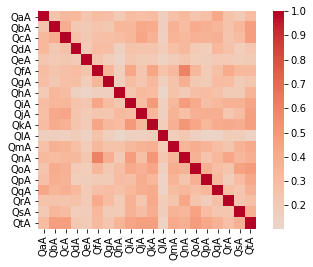

In [296]:
correlations = Answers.corr(method='spearman')
sns.heatmap(correlations, cmap="coolwarm", square=True, center=0)

Mach스코어는 몇몇 문항들, 즉 음의 부호를 갖는 문항들을 Reverse하여 평균을 구한 값이므로 Mach스코어 값을 train데이터셋에 추가시킵니다.

In [297]:
train['Mach_score'] = Answers.mean(axis = 1)
display(train.tail())

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,QfA,QfE,QgA,QgE,QhA,QhE,QiA,QiE,QjA,QjE,QkA,QkE,QlA,QlE,QmA,QmE,QnA,QnE,QoA,QoE,QpA,QpE,QqA,QqE,QrA,QrE,QsA,QsE,QtA,QtE,age_group,education,engnat,familysize,gender,hand,married,race,religion,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10,urban,voted,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13,Mach_score
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
45527,2.0,1050,5.0,619,4.0,328,1.0,285,1.0,602,1.0,267,1.0,315,1.0,483,1.0,1016,4.0,278,4.0,611,5.0,215,4.0,388,1.0,299,2.0,1915,4.0,439,2.0,823,1.0,309,5.0,586,4.0,2252,10s,2,1,1,Female,3,1,White,Jewish,1,2,6,1,2,6,3,0,6,4,3,2,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,1,4.15
45528,2.0,581,3.0,1353,4.0,1164,1.0,798,3.0,1680,2.0,560,2.0,640,1.0,1415,2.0,4494,5.0,1392,2.0,2478,5.0,1268,3.0,843,2.0,1401,4.0,1524,4.0,719,2.0,754,3.0,1118,4.0,654,4.0,1197,30s,2,1,2,Male,1,1,White,Atheist,2,2,2,3,1,3,3,4,1,5,1,2,0,0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,3.80
45529,4.0,593,1.0,857,1.0,1047,4.0,1515,5.0,1690,4.0,1253,5.0,1094,1.0,1283,5.0,2209,1.0,1764,5.0,1062,5.0,1489,1.0,1908,4.0,891,1.0,1298,1.0,1200,5.0,473,5.0,1779,3.0,1355,1.0,667,10s,2,1,1,Female,1,1,White,Christian_Other,4,4,2,4,0,1,0,2,1,6,2,1,0,0,0,1,1,0,1,1,0,1,1,0,1,0,1,1,1.50
45530,1.0,747,3.0,1331,4.0,892,2.0,1281,1.0,1328,1.0,599,1.0,650,1.0,1429,5.0,1748,1.0,770,5.0,1025,5.0,742,4.0,4180,3.0,707,1.0,489,1.0,913,4.0,1301,4.0,1680,4.0,737,1.0,1124,40s,4,1,2,Male,3,1,White,Atheist,1,2,0,4,0,1,3,2,2,4,0,1,0,0,0,1,1,0,1,1,0,1,1,1,1,0,1,1,2.90
45531,3.0,496,5.0,1827,5.0,754,3.0,1117,1.0,432,4.0,1422,3.0,545,3.0,1696,4.0,2172,4.0,7076,5.0,1087,5.0,1090,4.0,2195,4.0,431,4.0,914,4.0,620,4.0,410,4.0,736,4.0,667,5.0,1665,20s,2,1,3,Male,1,1,White,Agnostic,3,2,1,2,3,0,2,3,1,2,2,1,1,1,1,1,1,0,1,1,0,1,1,0,1,0,1,1,3.40


## 2-3-3. 수정된 Mach 스코어 계산

본 연구에서는 마키아벨리즘 심리테스트 문항들이 질문별로 국가선거 투표여부를 예측하는데 중요도의 차이가 존재한다고 가정하겠습니다.
따라서 랜덤포레스트 모델을 활용해 질문별 중요도를 산출하여, 이를 가중치로 적용하겠습니다.

In [298]:
train.columns

Index(['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE',
       'age_group', 'education', 'engnat', 'familysize', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'voted', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13',
       'Mach_score'],
      dtype='object')

In [299]:
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier


y = train['voted']

random_forest = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=0)
model1 = random_forest.fit(Answers, y)

In [300]:
test2 = test.copy()
columns = ['QaA', 'QbA', 'QcA', 'QdA', 'QeA',
           'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 
           'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 
           'QpA', 'QqA', 'QrA', 'QsA', 'QtA']
test2 = test2[columns]

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(5, shuffle=True, random_state=0)
cross_val_score(RandomForestClassifier(max_depth = 20), Answers, y, scoring="accuracy", cv=cv).mean()

In [ ]:
importances = pd.DataFrame({'Feature':Answers.columns,'Importance':np.round(random_forest.feature_importances_,3)})
importances_df = importances.sort_values('Importance', ascending=False).reset_index(drop=True)
importances_plot = importances.sort_values('Importance', ascending=False).set_index('Feature')
importances_plot

In [ ]:
#Plotting the Features importances
fig_bar_feature = go.Figure()
fig_bar_feature.add_trace(go.Bar(x=importances_df['Feature'], y=importances_df['Importance']))
fig_bar_feature.update_layout(width=800, title_text='Importances of Features',
                       xaxis_title_text='Features', yaxis_title_text='Importance', xaxis_tickangle=-45)
fig_bar_feature.show()

In [ ]:
Weighted_sum =Answers.dot(importances_plot)
Weighted_sum
train['revised_score'] = Weighted_sum
display(train.tail())

# Question을 이용한 feature 추출 예시

# 가설1: 고민 시간이 긴 질문은 영향을 많이 주는 질문일 것이다.-> Qd
plt.figure(figsize = (8,6))
sns.countplot(data = train, x = 'QdA', hue = train_y)

# 가설2: 특정 성향의 사람들은 답변 응답시간이 더 길 것이다.
def plot_to_voted(data, var, target):
    plt.figure(figsize = (8,6))
    for tar in target:
        u = np.percentile(data[data['voted']==tar][var],95)
        d = np.percentile(data[data['voted']==tar][var],5)
        column = [val for val in data[data['voted']==tar][var] if d < val < u]
        sns.distplot(column)
    plt.title(var)
    plt.legend(target)
    plt.show()

# Modeling

In [ ]:
# 변수 제거
drop_last = ['familysize', 'gender','hand','education', 'Mach_score']
new_train= train.drop(drop_last, axis = 1)


drop_last2 = ['familysize', 'gender','hand','education']
test = test.drop(drop_last2, axis = 1)

# PyCaret 패키지 설치

!pip install pycaret
from pycaret.classification import *

# 실험환경 구축

In [ ]:
# 'voted' 컬럼이 예측 대상이므로 target 인자에 명시

clf = setup(data = new_train, target = 'voted')

# 모델 학습 및 비교

In [ ]:
best_3 = compare_models(sort = 'AUC', n_select = 3)

# 모델 앙상블 (Model Ensemble)

In [ ]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

# 모델 예측(Prediction)

In [ ]:
pred_holdout = predict_model(blended)

# 전체 데이터에 대한 학습

In [ ]:
final_model = finalize_model(blended)

In [ ]:
# 대회용 test set에 대한 예측
predictions = predict_model(final_model, data = test)
predictions

In [ ]:
submission['voted'] = predictions['Score']

In [ ]:
submission['voted']=pred_y

In [ ]:
submission

In [ ]:
submission.to_csv('/sample_submission.csv')